In [8]:
import gymnasium as gym
import numpy as np
from copy import deepcopy
import torch
from torch.distributions import Normal
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions import Categorical
from torch.utils.data import Dataset, DataLoader
from stable_baselines3.common.vec_env import VecVideoRecorder, DummyVecEnv
import imageio
import pandas as pd
from tqdm import tqdm
from PIL import Image
from stable_baselines3.dqn.policies import MlpPolicy
import matplotlib.pyplot as plt


In [9]:
import gc
gc.collect()

514

In [10]:
!nvidia-smi

# clean up memory forcefully
torch.cuda.empty_cache()
torch.cuda.memory_summary(device=None, abbreviated=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device





Fri Apr 19 23:42:02 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 545.23.06              Driver Version: 545.23.06    CUDA Version: 12.3     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce GTX 1080 Ti     On  | 00000000:01:00.0 Off |                  N/A |
|  0%   35C    P2              54W / 250W |   1840MiB / 11264MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

device(type='cuda')

In [11]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
class CustomDataset(Dataset):
    def __init__(self, observations, actions):
        self.observations = torch.tensor(observations, dtype=torch.float32,device=device)
        self.actions = torch.tensor(actions, dtype=torch.float32,device=device)

    def __len__(self):
        return len(self.observations)

    def __getitem__(self, idx):
        observation = self.observations[idx]
        action = self.actions[idx]
        return observation, action

class PolicyNetwork(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(PolicyNetwork, self).__init__()
        self.fc1 = nn.Linear(input_dim, 32)
        self.norm1 = nn.LayerNorm(32)
        self.fc2 = nn.Linear(32, 32)
        self.norm2 = nn.LayerNorm(32)
        self.fc3 = nn.Linear(32, output_dim)
        torch.nn.init.kaiming_normal_(self.fc1.weight)
        torch.nn.init.kaiming_normal_(self.fc2.weight)
        torch.nn.init.kaiming_normal_(self.fc3.weight)

    def forward(self, x):
        x = F.relu(self.norm1(self.fc1(x)))
        x = F.relu(self.norm2(self.fc2(x)))
        x = self.fc3(x)
        return x

    

Using device: cuda


In [12]:
from imitation.util.util import make_vec_env

observations= np.load("../dataset/obs.npy", allow_pickle=True)
actions = np.load("../dataset/actions.npy", allow_pickle=True)
rewards = np.load("../dataset/rewards.npy", allow_pickle=True)
dones = np.load("../dataset/dones.npy", allow_pickle=True)
info = np.load("../dataset/info.npy", allow_pickle=True)
next_obs = np.load("../dataset/next_obs.npy", allow_pickle=True)
observations=observations.squeeze()
actions=actions.squeeze()
rewards=rewards.squeeze()
dones=dones.squeeze()
info=info.squeeze()
next_obs=next_obs.squeeze()

print(observations.shape, actions.shape, rewards.shape, dones.shape, info.shape, next_obs.shape)
print(observations[0], actions[0], rewards[0], dones[0], info[0], next_obs[0])
env = make_vec_env(
    "seals:seals/Walker2d-v1",
    rng=np.random.default_rng(),
    env_make_kwargs={"render_mode": "rgb_array"},
    n_envs=1,
)

(100000, 18) (100000, 6) (100000,) (100000,) (100000,) (100000, 18)
[ 1.36961687e-03  1.24769787e+00 -4.59026476e-03 -4.83472364e-03
  3.13270239e-03  4.12755577e-03  1.06635776e-03  2.29496561e-03
  4.36249915e-04  4.35072424e-03  3.15853554e-03 -4.97261500e-03
  3.57404277e-03 -4.66414425e-03  2.29655446e-03 -3.24344379e-03
  3.63178922e-03  4.14612202e-04] [1.        1.        0.9766268 1.        0.1786359 1.       ] 1.1278079 False {'x_position': 0.002431965734592546, 'x_velocity': 0.13279360767225037, 'TimeLimit.truncated': False} [ 2.43196573e-03  1.24594578e+00 -8.64441604e-04 -1.14463408e-03
  3.10100134e-03  5.86868264e-02  3.56366528e-03  2.25989286e-03
  5.70766729e-02  2.47718944e-01 -4.40264873e-01  8.48866739e-01
  8.48918506e-01  1.11113961e-03  1.00000000e+01  5.52236742e-01
 -2.65369722e-03  1.00000000e+01]


In [13]:
class mydataset(Dataset):
    def __init__(self, observations, actions):
        self.observations = torch.tensor(observations, dtype=torch.float32).to(device)
        self.actions = torch.tensor(actions, dtype=torch.float32).to(device)

    def __len__(self):
        return len(self.observations)

    def __getitem__(self, idx):
        observation = self.observations[idx]
        action = self.actions[idx]
        return observation, action

In [14]:
policy_network = PolicyNetwork(18,6).to(device)
prev = PolicyNetwork(18,6).to(device)
prev.load_state_dict(policy_network.state_dict())
prev.eval()

optimizer = torch.optim.Adam(policy_network.parameters(), lr=1e-3,weight_decay=1e-4)

# Training loop
num_epochs = 100
batch_size = 32

dataset = mydataset(observations=observations, actions=actions)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

loss_graph=[]
score_graph=[]
margin_graph=[]
positive_reward_graph=[]
negative_reward_graph=[]
log_interval = len(observations)//1
num_test = 10
now_log=0
now_pos=0
score=0
for epoch in range(num_epochs):
    policy_network.train()

    # Compute the log probabilities of the actions
    pbar=tqdm(dataloader,position=0,leave=True)
    now_log=0

    for step, (obs_batch,act_batch) in enumerate(pbar):
        # obs_batch = torch.tensor(np.array(obs_batch), dtype=torch.float32).to(device)
        # act_batch = torch.tensor(np.array(act_batch), dtype=torch.float32).to(device)

        now_log+=obs_batch.shape[0]
        now_pos+=obs_batch.shape[0]
        model_act= torch.tanh( policy_network(obs_batch))
        loss= F.mse_loss(model_act,act_batch)

        optimizer.zero_grad()



        loss.backward()

        optimizer.step()
        pbar.set_description((f"Epoch [{epoch+1}/{num_epochs}]"))
        loss_graph.append(loss.detach().item())




        total_reward=0
        if now_log>=log_interval:
            now_log-=log_interval
            
            policy_network.eval()  # 切换到评估模式

            

            total_reward=0
            # test the policy and save as the first test as gif
            for _ in range(num_test):
                state = env.reset()
                done = False
                while not done:
                    state_tensor = torch.tensor([state], dtype=torch.float32).to(device)
                    with torch.no_grad():
                        action= torch.tanh(policy_network(state_tensor))
                        action.squeeze_()
                    state, reward, done, _ = env.step([action.cpu().numpy()])  # 执行动作
                    total_reward += reward

            score=total_reward/num_test
            score_graph.append(score)
            policy_network.train()  # 切换回训练模式
        pbar.set_postfix({"loss":loss.detach().item(), "score":score})

         

env.close()

Epoch [1/100]:  99%|█████████▉| 3089/3125 [00:08<00:00, 395.80it/s, loss=0.0133, score=0] /tmp/ipykernel_2507565/3987936990.py:68: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /opt/conda/conda-bld/pytorch_1708025847094/work/torch/csrc/utils/tensor_new.cpp:275.)
  state_tensor = torch.tensor([state], dtype=torch.float32).to(device)
Epoch [100/100]: 100%|██████████| 3125/3125 [00:12<00:00, 242.40it/s, loss=0.0022, score=[2603.6912]]  


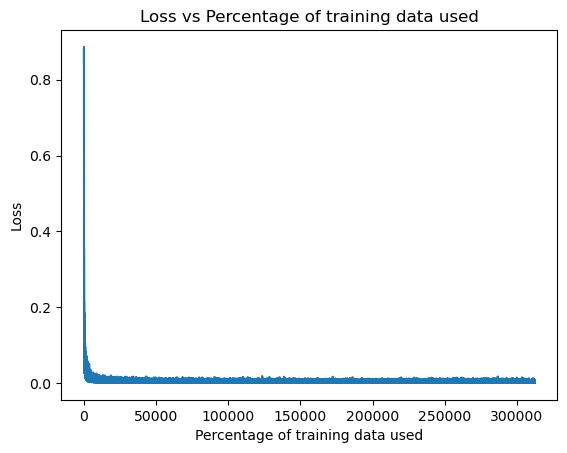

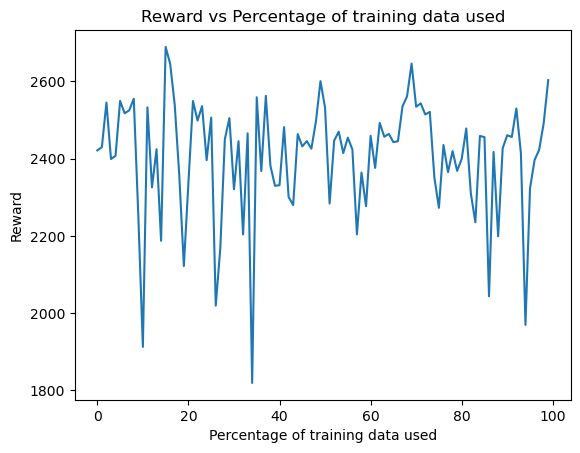

In [16]:
# draw the loss graph
import matplotlib.pyplot as plt
plt.plot(loss_graph)
plt.xlabel("Percentage of training data used")
plt.ylabel("Loss")
plt.title("Loss vs Percentage of training data used")

plt.savefig("./loss.png")
plt.show()
# draw the reward graph
plt.plot(score_graph)
plt.xlabel("Percentage of training data used")
plt.ylabel("Reward")
plt.title("Reward vs Percentage of training data used")
plt.savefig("./reward.png")
plt.show()


